In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.stats import pearsonr, false_discovery_control

from utils import get_expasy_peptide_mass, get_uniprotkbid

sns.set_theme(style="darkgrid")

# Load the data
Load the normalized data for the selected microdissociations

In [2]:
# load the counts data
counts = pd.read_csv("data/PDAC_MICRODISSEC_NAIF/rna_seq_vst.csv", index_col=0)

# load the immuno counts data frame
immuno_counts = pd.read_csv('data/MALDI_IHC/results/immuno_counts_vst.csv', index_col=0)

In [3]:
# load the matirisom genes
matrisome_genes = pd.read_csv("Hs_Matrisome_Masterlist_2012.csv")

# load the gene annotation
gene_annotation = pd.read_csv("geneAnnot.tsv", sep="\t")

## Add the gene id to the matrisome genes

In [4]:
# Define the Gene_Id column in the matrisome_genes dataframe
def get_gene_id(gene_symbol, gene_annotation):
    gene_id = gene_annotation[gene_annotation["GeneName"] == gene_symbol]["GeneID"].values
    return gene_id[0] if len(gene_id) > 0 else None

matrisome_genes["Gene_Id"] = matrisome_genes["Gene Symbol"].apply(lambda x: get_gene_id(x, gene_annotation))

## Clean the matrisome_genes dataframe

In [5]:
# Replace the " " by _ in the column names
matrisome_genes.columns = matrisome_genes.columns.str.replace(" ", "_")
immuno_counts.columns = immuno_counts.columns.str.replace(" ", "_")
immuno_counts.columns = immuno_counts.columns.str.replace(".", "_")

# Clean the matrisome_genes unwanted columns
matrisome_genes = matrisome_genes.drop(columns=["Gene_Name", "Synonyms", "HGNC_IDs", "HGNC_IDs_Links", "UniProt_IDs", "Refseq_IDs", "Notes"])

# Rorder the columns
matrisome_genes = matrisome_genes[["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category"]]

# Remove the matrisome genes that are not in the counts data
matrisome_genes = matrisome_genes[matrisome_genes["Gene_Id"].isin(counts.index)]

In [6]:
# Clean the counts to include only the genes in the matrisome_genes
counts = counts.loc[matrisome_genes.Gene_Id]

In [7]:
# Compute the correlation between the counts and the densities
for cell_type in immuno_counts.columns:
    correlations = []
    pvalues = []
    for gene in counts.index:
        corr, pvalu = pearsonr(counts.loc[gene], immuno_counts[cell_type])
        correlations.append(corr)
        pvalues.append(pvalu)
        qvalues = false_discovery_control(ps=pvalues, method="bh")

    matrisome_genes[cell_type] = correlations
    matrisome_genes[cell_type + "_p"] = pvalues
    matrisome_genes[cell_type + "_q"] = qvalues

matrisome_genes.head()

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,Tcells,Tcells_p,Tcells_q,CD8Tcells,CD8Tcells_p,CD8Tcells_q,...,Myeloid_dendritic_q,Neutrophils,Neutrophils_p,Neutrophils_q,Endothelial,Endothelial_p,Endothelial_q,Fibroblasts,Fibroblasts_p,Fibroblasts_q
0,ENSG00000154175,ABI3BP,Core matrisome,ECM Glycoproteins,0.166893,0.000952,0.002148,-0.004962,9.222878e-01,9.492159e-01,...,0.000033,-0.007373,8.847434e-01,0.917271,0.291248,4.822452e-09,1.933552e-08,0.020555,6.861026e-01,7.451128e-01
1,ENSG00000181092,ADIPOQ,Core matrisome,ECM Glycoproteins,0.242951,0.000001,0.000006,0.283604,1.249444e-08,1.651609e-07,...,0.000008,0.246364,8.678798e-07,0.000006,0.419097,5.607191e-18,1.395201e-16,-0.100158,4.837722e-02,7.579098e-02
2,ENSG00000106624,AEBP1,Core matrisome,ECM Glycoproteins,-0.183215,0.000280,0.000719,-0.095575,5.966193e-02,1.076205e-01,...,0.424136,0.065673,1.961853e-01,0.279415,0.112240,2.685637e-02,3.812163e-02,0.836970,2.303028e-103,1.498739e-101
3,ENSG00000188157,AGRN,Core matrisome,ECM Glycoproteins,-0.224180,0.000008,0.000030,-0.099730,4.935002e-02,9.298466e-02,...,0.098329,0.185956,2.259947e-04,0.000747,-0.076534,1.318512e-01,1.659913e-01,0.104677,3.905671e-02,6.378760e-02
7,ENSG00000242252,BGLAP,Core matrisome,ECM Glycoproteins,0.006960,0.891160,0.909435,-0.062594,2.180301e-01,3.074614e-01,...,0.000874,-0.057400,2.587301e-01,0.350778,0.109939,3.016377e-02,4.260192e-02,0.013740,7.870486e-01,8.304837e-01


In [10]:
# Exclude the pvalues and qvalues columns
corr_genes = matrisome_genes.drop(columns=[col for col in matrisome_genes.columns if "_p" in col] + [col for col in matrisome_genes.columns if "_q" in col])

# Melt the data to have the Cell_type as a column
corr_staining = corr_genes.melt(id_vars=["Gene_Id", "Matrisome_Division", "Matrisome_Category", "Gene_Symbol"],
                                var_name="Cell_type",
                                value_name="Correlation")

# Filter the data to have only the Tumor and Stroma staining
corr_tumor_stroma = corr_staining[corr_staining["Cell_type"].isin(["Tumor", "Stroma"])]

# Melt the data to have the Matrisome Division as a column
corr_division = corr_genes.melt(id_vars=["Gene_Id", "Matrisome_Category", "Gene_Symbol", "Tcells", "CD8Tcells", "Cytotox_lymph", "NK", "B_lineage", "Mono_lineage", "Myeloid_dendritic", "Neutrophils", "Endothelial", "Fibroblasts"],
                                var_name="Matrisome_Division",
                                value_name="Division")

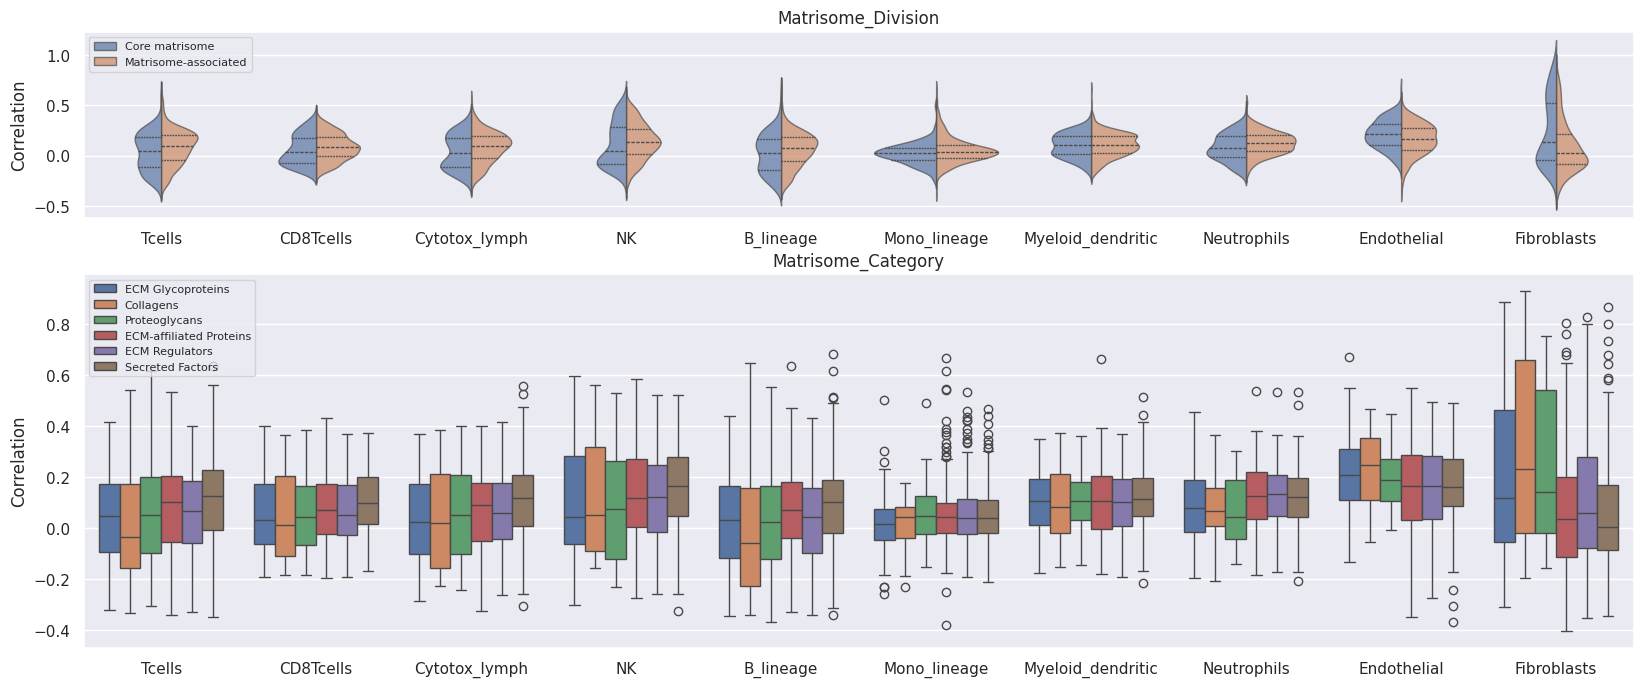

In [11]:
# Draw a violin plot of the correlation values for each Matrisome Division and Matrisome Category
fig, ax = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [1, 2]})
sns.violinplot(x="Cell_type", y="Correlation", data=corr_staining, hue="Matrisome_Division", ax=ax[0], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[0].set_title("Matrisome_Division")
ax[0].set_xlabel("")
ax[0].set_ylabel("Correlation")
ax[0].legend(loc='upper left', fontsize=8)

sns.boxplot(x="Cell_type", y="Correlation", data=corr_staining, hue="Matrisome_Category", ax=ax[1], linewidth=1)
ax[1].set_title("Matrisome_Category")
ax[1].set_xlabel("")
ax[1].set_ylabel("Correlation")
ax[1].legend(loc='upper left', fontsize=8)

plt.show()

# Find the highest correlated and anti-correlated genes with CD8

In [12]:
# Find the top genes with the highest correlation with CD8
top_genes = matrisome_genes.nlargest(20, 'CD8Tcells')
top_genes.loc[:, ["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category", "Tcells" ,"Tcells_p", "Tcells_q", "CD8Tcells", "CD8Tcells_p", "CD8Tcells_q", "Cytotox_lymph", "Cytotox_lymph_p", "Cytotox_lymph_q"]]

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,Tcells,Tcells_p,Tcells_q,CD8Tcells,CD8Tcells_p,CD8Tcells_q,Cytotox_lymph,Cytotox_lymph_p,Cytotox_lymph_q
347,ENSG00000183090,FREM3,Matrisome-associated,ECM-affiliated Proteins,0.264077,1.251758e-07,8.609655e-07,0.432274,3.838729e-19,3.247565e-16,0.284950,1.058673e-08,1.336773e-07
48,ENSG00000142449,FBN3,Core matrisome,ECM Glycoproteins,0.262746,1.455054e-07,9.617000e-07,0.402444,1.409530e-16,5.962313e-14,0.295182,2.921730e-09,4.753430e-08
382,ENSG00000205592,MUC19,Matrisome-associated,ECM-affiliated Proteins,0.345258,2.484629e-12,6.780633e-11,0.392514,8.862159e-16,2.499129e-13,0.354454,5.862620e-13,1.907606e-11
254,ENSG00000112706,IMPG1,Core matrisome,Proteoglycans,0.230495,4.360124e-06,1.756507e-05,0.383344,4.584399e-15,9.696005e-13,0.294848,3.049630e-09,4.865010e-08
994,ENSG00000106952,TNFSF8,Matrisome-associated,Secreted Factors,0.559203,2.211560e-33,4.677450e-31,0.372346,3.078106e-14,5.208155e-12,0.449475,9.670144e-21,1.806414e-18
567,ENSG00000113889,KNG1,Matrisome-associated,ECM Regulators,0.241344,1.463870e-06,6.767398e-06,0.369947,4.619138e-14,6.512984e-12,0.256545,2.902287e-07,2.316354e-06
205,ENSG00000082293,COL19A1,Core matrisome,Collagens,0.543110,3.152230e-31,4.444645e-29,0.363896,1.266600e-13,1.530776e-11,0.380760,7.217466e-15,4.070651e-13
671,ENSG00000125780,TGM3,Matrisome-associated,ECM Regulators,0.261862,1.607392e-07,1.035550e-06,0.360729,2.129600e-13,2.252052e-11,0.354544,5.778887e-13,1.907606e-11
740,ENSG00000271503,CCL5,Matrisome-associated,Secreted Factors,0.519379,2.954748e-28,2.777463e-26,0.353686,6.626461e-13,6.228874e-11,0.525759,4.948111e-29,2.093051e-26
442,ENSG00000168878,SFTPB,Matrisome-associated,ECM-affiliated Proteins,0.289616,5.923283e-09,6.738230e-08,0.352589,7.887742e-13,6.566828e-11,0.239868,1.703435e-06,1.036767e-05


In [13]:
# Find the top genes with the lowest correlation with CD8
bottom_genes = matrisome_genes.nsmallest(20, 'CD8Tcells')
bottom_genes.loc[:, ["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category", "Tcells" ,"Tcells_p", "Tcells_q", "CD8Tcells", "CD8Tcells_p", "CD8Tcells_q", "Cytotox_lymph", "Cytotox_lymph_p", "Cytotox_lymph_q"]]

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,Tcells,Tcells_p,Tcells_q,CD8Tcells,CD8Tcells_p,CD8Tcells_q,Cytotox_lymph,Cytotox_lymph_p,Cytotox_lymph_q
278,ENSG00000182718,ANXA2,Matrisome-associated,ECM-affiliated Proteins,-0.337407,8.214898e-12,2.044060e-10,-0.196129,0.000099,0.000437,-0.325406,4.793383e-11,1.158629e-09
677,ENSG00000035862,TIMP2,Matrisome-associated,ECM Regulators,-0.299965,1.572386e-09,2.224074e-08,-0.189850,0.000165,0.000696,-0.259756,2.034359e-07,1.738452e-06
153,ENSG00000102359,SRPX2,Core matrisome,ECM Glycoproteins,-0.281891,1.540527e-08,1.416615e-07,-0.188801,0.000180,0.000750,-0.283472,1.269770e-08,1.579743e-07
253,ENSG00000142798,HSPG2,Core matrisome,Proteoglycans,-0.239893,1.699164e-06,7.728457e-06,-0.183148,0.000282,0.001116,-0.219497,1.250374e-05,5.735685e-05
228,ENSG00000142156,COL6A1,Core matrisome,Collagens,-0.164110,1.160611e-03,2.563648e-03,-0.181227,0.000327,0.001276,-0.152050,2.640576e-03,5.982399e-03
111,ENSG00000101825,MXRA5,Core matrisome,ECM Glycoproteins,-0.287380,7.834025e-09,8.284482e-08,-0.179392,0.000377,0.001428,-0.248207,7.142855e-07,4.834285e-06
348,ENSG00000063660,GPC1,Matrisome-associated,ECM-affiliated Proteins,-0.268553,7.499497e-08,5.376758e-07,-0.176635,0.000465,0.001718,-0.262428,1.508229e-07,1.315424e-06
420,ENSG00000075223,SEMA3C,Matrisome-associated,ECM-affiliated Proteins,-0.227775,5.685781e-06,2.195656e-05,-0.172436,0.000636,0.002300,-0.251165,5.208315e-07,3.707574e-06
69,ENSG00000115461,IGFBP5,Core matrisome,ECM Glycoproteins,-0.180832,3.374879e-04,8.472247e-04,-0.170141,0.000753,0.002654,-0.250539,5.570062e-07,3.926893e-06
240,ENSG00000106819,ASPN,Core matrisome,Proteoglycans,-0.198454,8.121584e-05,2.313421e-04,-0.166790,0.000959,0.003273,-0.205451,4.451298e-05,1.715577e-04


# Foucs on the core matrisome genes

In [14]:
# Remove the secreted factors
matrisome_genes_core = matrisome_genes[matrisome_genes.Matrisome_Division != "Matrisome-associated"]

In [15]:
# Find the top genes with the highest correlation with CD8
top_genes = matrisome_genes_core.nlargest(20, 'CD8Tcells')
top_genes.loc[:, ["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category", "Tcells" ,"Tcells_p", "Tcells_q", "CD8Tcells", "CD8Tcells_p", "CD8Tcells_q", "Cytotox_lymph", "Cytotox_lymph_p", "Cytotox_lymph_q"]]

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,Tcells,Tcells_p,Tcells_q,CD8Tcells,CD8Tcells_p,CD8Tcells_q,Cytotox_lymph,Cytotox_lymph_p,Cytotox_lymph_q
48,ENSG00000142449,FBN3,Core matrisome,ECM Glycoproteins,0.262746,1.455054e-07,9.617000e-07,0.402444,1.409530e-16,5.962313e-14,0.295182,2.921730e-09,4.753430e-08
254,ENSG00000112706,IMPG1,Core matrisome,Proteoglycans,0.230495,4.360124e-06,1.756507e-05,0.383344,4.584399e-15,9.696005e-13,0.294848,3.049630e-09,4.865010e-08
205,ENSG00000082293,COL19A1,Core matrisome,Collagens,0.543110,3.152230e-31,4.444645e-29,0.363896,1.266600e-13,1.530776e-11,0.380760,7.217466e-15,4.070651e-13
97,ENSG00000162510,MATN1,Core matrisome,ECM Glycoproteins,0.261158,1.739507e-07,1.106483e-06,0.352088,8.538429e-13,6.566828e-11,0.214559,1.972720e-05,8.471682e-05
157,ENSG00000119913,TECTB,Core matrisome,ECM Glycoproteins,0.157439,1.841719e-03,3.856669e-03,0.343286,3.365830e-12,1.884590e-10,0.221079,1.078052e-05,5.123774e-05
41,ENSG00000188107,EYS,Core matrisome,ECM Glycoproteins,0.320184,1.008324e-10,1.895649e-09,0.342912,3.564237e-12,1.884590e-10,0.293636,3.560738e-09,5.379258e-08
126,ENSG00000188162,OTOG,Core matrisome,ECM Glycoproteins,0.244119,1.098027e-06,5.278018e-06,0.338600,6.865482e-12,3.226776e-10,0.277185,2.718869e-08,3.108329e-07
191,ENSG00000103310,ZP2,Core matrisome,ECM Glycoproteins,0.170556,7.305768e-04,1.731283e-03,0.337916,7.610219e-12,3.388550e-10,0.196595,9.494998e-05,3.239019e-04
270,ENSG00000107742,SPOCK2,Core matrisome,Proteoglycans,0.617102,3.411708e-42,1.443153e-39,0.333972,1.371758e-11,5.802536e-10,0.402601,1.368664e-16,1.404480e-14
231,ENSG00000172752,COL6A5,Core matrisome,Collagens,0.309620,4.346828e-10,7.504931e-09,0.330466,2.300067e-11,8.107736e-10,0.354801,5.546238e-13,1.907606e-11


In [16]:
# Find the top genes with the lowest correlation with CD8
bottom_genes = matrisome_genes_core.nsmallest(20, 'CD8Tcells')
bottom_genes.loc[:, ["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category", "Tcells" ,"Tcells_p", "Tcells_q", "CD8Tcells", "CD8Tcells_p", "CD8Tcells_q", "Cytotox_lymph", "Cytotox_lymph_p", "Cytotox_lymph_q"]]

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,Tcells,Tcells_p,Tcells_q,CD8Tcells,CD8Tcells_p,CD8Tcells_q,Cytotox_lymph,Cytotox_lymph_p,Cytotox_lymph_q
153,ENSG00000102359,SRPX2,Core matrisome,ECM Glycoproteins,-0.281891,1.540527e-08,1.416615e-07,-0.188801,0.000180,0.000750,-0.283472,1.269770e-08,1.579743e-07
253,ENSG00000142798,HSPG2,Core matrisome,Proteoglycans,-0.239893,1.699164e-06,7.728457e-06,-0.183148,0.000282,0.001116,-0.219497,1.250374e-05,5.735685e-05
228,ENSG00000142156,COL6A1,Core matrisome,Collagens,-0.164110,1.160611e-03,2.563648e-03,-0.181227,0.000327,0.001276,-0.152050,2.640576e-03,5.982399e-03
111,ENSG00000101825,MXRA5,Core matrisome,ECM Glycoproteins,-0.287380,7.834025e-09,8.284482e-08,-0.179392,0.000377,0.001428,-0.248207,7.142855e-07,4.834285e-06
69,ENSG00000115461,IGFBP5,Core matrisome,ECM Glycoproteins,-0.180832,3.374879e-04,8.472247e-04,-0.170141,0.000753,0.002654,-0.250539,5.570062e-07,3.926893e-06
240,ENSG00000106819,ASPN,Core matrisome,Proteoglycans,-0.198454,8.121584e-05,2.313421e-04,-0.166790,0.000959,0.003273,-0.205451,4.451298e-05,1.715577e-04
132,ENSG00000133110,POSTN,Core matrisome,ECM Glycoproteins,-0.239268,1.811180e-06,8.064515e-06,-0.165603,0.001044,0.003491,-0.175529,5.053947e-04,1.413241e-03
225,ENSG00000130635,COL5A1,Core matrisome,Collagens,-0.273708,4.108821e-08,3.238001e-07,-0.165108,0.001081,0.003602,-0.219173,1.288808e-05,5.862000e-05
230,ENSG00000163359,COL6A3,Core matrisome,Collagens,-0.202624,5.689129e-05,1.673551e-04,-0.161513,0.001392,0.004461,-0.202746,5.629597e-05,2.061749e-04
149,ENSG00000262655,SPON1,Core matrisome,ECM Glycoproteins,-0.226744,6.281983e-06,2.388347e-05,-0.160635,0.001479,0.004666,-0.268361,7.667979e-08,8.108888e-07


# Get the peptide mass
Get a UniProtKB list of protein ids for each gene then get the peptide masses for each protein using ExPASy peptide mass tool.

In [17]:
# Peptides mass path
peptides_mass_path = "data/MALDI_IHC/results/peptides_mass_immuno_counts"

# Create the directory if it does not exist
os.makedirs(peptides_mass_path, exist_ok=True)

# Get the gene names for the top and bottom genes and remove duplicates
genes = pd.concat([top_genes, bottom_genes])['Gene_Symbol'].unique()

# Get the peptide mass for each gene
for gene in genes:
    print(f"\nGene: {gene}")

    # Get a list of protein names for the gene
    protein_names = get_uniprotkbid(gene)
    
    # Get the peptide mass for each protein name
    for protein_name in protein_names:
        print(f"Protein: {protein_name}")

        # Check if the file already exists
        if not os.path.exists(f"{peptides_mass_path}/{protein_name}_peptide_mass.csv"):

            # Get the peptide mass
            peptide_mass = get_expasy_peptide_mass(protein_name)
            print(f"{peptide_mass.shape[0]} peptides")

            # Save the peptide mass to a csv file
            peptide_mass.to_csv(f"{peptides_mass_path}/{protein_name}_peptide_mass.csv", index=False)


Gene: FBN3
Protein: FBN3_HUMAN
130 peptides

Gene: IMPG1
Protein: IMPG1_HUMAN
45 peptides

Gene: COL19A1
Protein: COJA1_HUMAN
71 peptides

Gene: MATN1
Protein: MATN1_HUMAN
34 peptides

Gene: TECTB
Protein: TECTB_HUMAN
16 peptides

Gene: EYS
Protein: EYS_HUMAN
163 peptides

Gene: OTOG
Protein: OTOG_HUMAN
127 peptides

Gene: ZP2
Protein: ZP2_HUMAN
33 peptides

Gene: SPOCK2
Protein: TICN2_HUMAN
27 peptides

Gene: COL6A5
Protein: CO6A5_HUMAN
175 peptides

Gene: NELL1
Protein: NELL1_HUMAN
51 peptides

Gene: SLIT1
Protein: SLIT1_HUMAN
74 peptides

Gene: TNR
Protein: TENR_HUMAN
69 peptides

Gene: VIT
Protein: VITRN_HUMAN
44 peptides

Gene: NCAN
Protein: NCAN_HUMAN
56 peptides

Gene: COL11A2
Protein: COBA2_HUMAN
103 peptides

Gene: LAMB4
Protein: LAMB4_HUMAN
95 peptides

Gene: BCAN
Protein: PGCB_HUMAN
47 peptides

Gene: LGI1
Protein: LGI1_HUMAN
32 peptides

Gene: DMP1
Protein: DMP1_HUMAN
21 peptides
Protein: DMTF1_HUMAN
29 peptides

Gene: SRPX2
Protein: SRPX2_HUMAN
30 peptides

Gene: HSPG2
Pr

# Make a reference of the correlated peptides mass

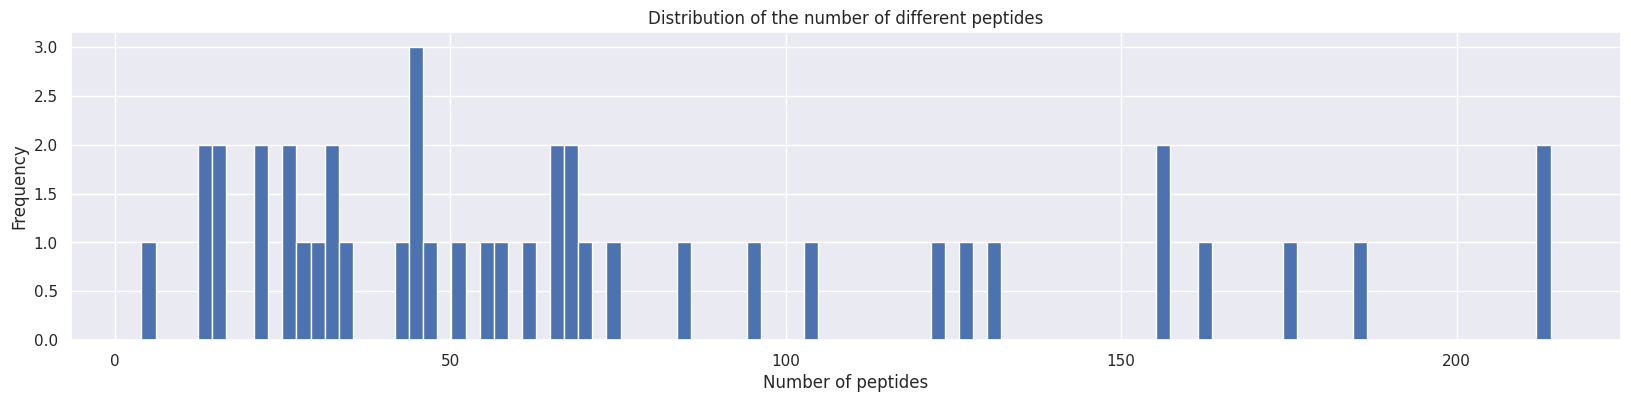

Number of proteins: 42
Number of proteins with less than 100 peptides: 31
Number of proteins with more than 100 peptides: 11


In [18]:
# Extract the protein peptide masses
masses = [pd.read_csv(f"{peptides_mass_path}/{protein}")["mass"] for protein in os.listdir(peptides_mass_path)]

masses_number = [len(mass) for mass in masses]

# Plot the distribution of the peptide masses number
plt.figure(figsize=(20, 4))
plt.hist(masses_number, bins=100)
plt.xlabel("Number of peptides")
plt.ylabel("Frequency")
plt.title("Distribution of the number of different peptides")
plt.show()

print(f"Number of proteins: {len(masses)}")
print(f"Number of proteins with less than 100 peptides: {sum([1 for mass in masses_number if mass < 100])}")
print(f"Number of proteins with more than 100 peptides: {sum([1 for mass in masses_number if mass > 100])}")

In [19]:
# # pool the peptide masses of all the proteins with number of peptides < 100
# masses_pool = np.concatenate([mass for mass in masses if len(mass) < 100])

# pool the peptide masses of all the proteins
masses_pool = np.concatenate(masses)

# Sort the masses pool
masses_pool = np.sort(masses_pool)

# Build a reference of unique masses
unique_masses = np.unique(masses_pool)

print(f"Number of unique masses: {unique_masses.shape[0]}")
print(f"Number of duplicated masses: {masses_pool.shape[0] - unique_masses.shape[0]}")

Number of unique masses: 2964
Number of duplicated masses: 140


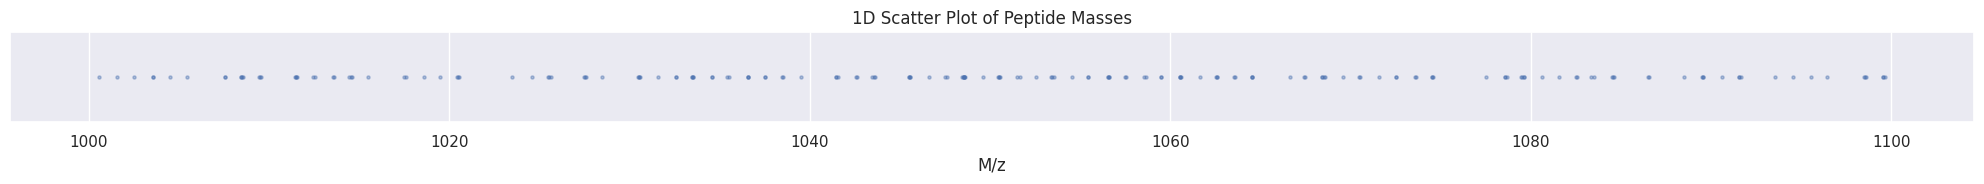

In [20]:
# Sample array of masses
masses_sample = masses_pool[(masses_pool > 1000) & (masses_pool < 1100)] 

plt.figure(figsize=(20, 2), tight_layout=True)
plt.scatter(masses_sample, [0]*len(masses_sample), s=5, alpha=0.4)
plt.xlabel("M/z")
plt.title("1D Scatter Plot of Peptide Masses")
plt.yticks([])
plt.show()

In [21]:
# Save the unique masses to a csv file
pd.DataFrame(unique_masses, columns=["mass"]).to_csv("data/MALDI_IHC/results/correlated_masses_reference_immuno_counts.csv", index=False)